In [1]:
import pandas as pd
import numpy as np
import csv
from scipy import stats
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import datetime
from datetime import datetime, timedelta
import holidays
pd.options.display.max_rows = 50
import json
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.2f}'.format

In [2]:
from scipy.optimize import minimize

In [68]:
def DailyModel(daily_data):
    '''Calls all daily models, returns dictionary'''
    estimated_daily = {}
    estimated_daily['Daily'] = Model1(daily_data)
    return Model1(daily_data)

def arma_ale(daily_data):
    ''' put it all together (make sure the date you want is within the testing set'''
    modified_data = prep_data(daily_data)
    train, test = split_dataset(modified_data, 0.7)
    y_true = train['y_true'].values
    res = minimize(my_objective, np.array([0.5, 0.5], dtype=float), args=train['y_true'].values)
    phi, theta = res.x
    test['y_hat'] = estimate_y(test['y_true'].values, phi, theta,0.7)
    test['log_total_vol_hat'] = test['y_hat'] + test['log_20days_AM']
    return test, phi, theta

def Model1(daily_data):
    output = arma_ale(daily_data)
    return output[0]['log_total_vol_hat'], output[1], output[2]

def prep_data(daily_data):
    '''
    Dataset preparation
    Input:
        csv_file (csv str) : your stock dataset
        stock (str) : your chosen stock capitalized symbol
    Output:
         dataset
    '''
    daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).rolling(20).mean()
    daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM'].shift()
    data = daily_data[20:]
    data['log_total_vol_m'] = np.log(data['total_vol_m'])
    data.set_index('DATE', inplace=True)

    return data

def split_dataset(dataset, split_level):
    '''Split dataset into training set and testing set.'''
    n = int(len(dataset) * split_level)
    train = dataset[:n]
    test = dataset[n:]
    train.loc[:,'y_hat'] = estimate_y(train['y_true'].values, 0.7, -0.3, False)
    return train, test

# find y_hat given y_true
# with unknown eps, phi, theta, we need to calculate them recursively
# here assume the initial eps, which represents the error is zero
def estimate_y(y_true, phi, theta, predict):
    '''
    Calculate y_hat based on known y_true
    Input:
        y_true (array): log(Vt) - 20-day moving average
        phi(float): universal standard is about 0.7
        theta(float): universal standard is about -0.3
    Outputs:
        y_hat (array):estimated y_true
    '''
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1, n):
        y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
        eps[t] = y_true[t] - y_hat[t]

    if predict:
        predict_y = phi * y_true[-1] + theta * eps[-1]
        return predict_y
    else:
        return y_hat

def my_objective(param, y_true):
    '''
    Objective loss function for minimizing
    Find the Weighted Asymmetrical Logarithmic Error
    Input:
        param(float array): potential phi and theta
        y_true (array): log(Vt) - 20-day moving average
    Outputs:
        ALE, weighted asymmetrical logarithmic error
    '''
    phi = param[0]
    theta = param[1]
    y_hat = estimate_y(y_true, phi, theta,0.7)
    y_diff = y_hat - y_true
    #ALE = np.sum((1.5 + 0.5 * np.sign(y_diff)) * np.abs(y_diff))
    L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
    return L1_v

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59073/2399445919.py:64: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59073/2399445919.py:64: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59073/2399445919.py:64: RuntimeWarning: overflow encountered in double_scalars
  y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59073/2399445919.py:64: RuntimeWarn

<function matplotlib.pyplot.show(close=None, block=None)>

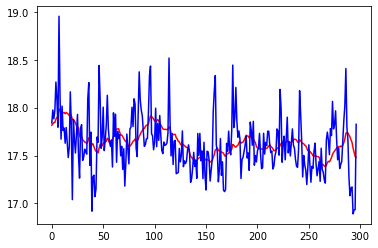

In [106]:
stock=sp.loc[sp.symbol == 'BAC']
theory = DailyModel(stock)[0].reset_index(drop=True)
practice = stock.loc[stock.DATE > '2020-10-28'].log_vol.reset_index(drop=True)
plt.plot(theory, color = 'r')
plt.plot(practice, color = 'b')
plt.show

In [73]:
sp = pd.read_csv("rhupna2taemg8rjb.csv")
sp['log_vol'] = np.log(sp.total_vol_m)
sp['DATE']= pd.to_datetime(sp.DATE)
sp['log_vol'] = np.log(sp.total_vol_m)
tickers = sp.symbol.unique()
days = sp.DATE.unique()

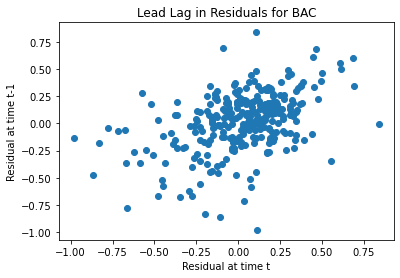

In [108]:
plt.scatter((theory - practice).shift(),theory - practice)
plt.ylabel('Residual at time t-1')
plt.xlabel('Residual at time t')
plt.title('Lead Lag in Residuals for BAC')
plt.savefig('RESIDUAL_BAC.png', dpi=300)

In [84]:
stock.loc[stock.DATE > '2020-10-28'].log_vol.reset_index(drop=True)

0     14.24
1     15.26
2     14.69
3     14.22
4     15.03
       ... 
292   13.71
293   13.62
294   13.30
295   13.58
296   13.95
Name: log_vol, Length: 297, dtype: float64

In [42]:
sp.loc[sp.symbol == 'MRNA']

,DATE,SYM_ROOT,symbol,CPrc,OPrc,total_vol_m,log_vol
147954,2018-12-07,MRNA,MRNA,18.60,22.00,10701654.00,16.19
148582,2018-12-10,MRNA,MRNA,18.80,18.90,4128370.00,15.23
149214,2018-12-11,MRNA,MRNA,18.01,20.55,3302474.00,15.01
149845,2018-12-12,MRNA,MRNA,18.68,18.55,2572439.00,14.76
150477,2018-12-13,MRNA,MRNA,18.76,19.25,1597681.00,14.28
...,...,...,...,...,...,...,...
647198,2021-12-28,MRNA,MRNA,241.44,246.00,8789834.00,15.99
647848,2021-12-29,MRNA,MRNA,247.88,240.00,8902129.00,16.00
648498,2021-12-30,MRNA,MRNA,251.60,243.42,6424599.00,15.68
649147,2021-12-31,MRNA,MRNA,253.98,249.88,6670646.00,15.71


#### To get the sector residual first - Sample: TECH

In [43]:
AAPL = sp.loc[sp.symbol == 'AAPL'].reset_index(drop=True)

(711    18.56
 712    18.59
 713    19.01
 714    18.37
 715    18.54
         ... 
 1003   18.28
 1004   18.25
 1005   17.96
 1006   18.06
 1007   18.03
 Name: log_total_vol_hat, Length: 297, dtype: float64,
 0.5,
 0.5)

In [128]:
BAC = BAC.reset_index(drop=True)
two = BAC.loc[BAC.index > 710].log_vol

0.013514638911644757

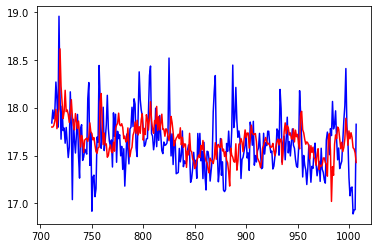

In [145]:
plt.plot(two, color = 'b')
plt.plot(one,color = 'r')
loss_function(two,one)/300

In [13]:
sector_error = np.log(TECH[TECH.index >= '2019-09-24']['total_vol_m']) - DailyModel(TECH)[0]
sector_error

DATE
2019-06-07     NaN
2019-06-10     NaN
2019-06-11     NaN
2019-06-12     NaN
2019-06-13     NaN
              ... 
2019-12-27   -0.29
2019-12-30   -0.19
2019-12-31   -0.30
2020-01-02    0.18
2020-01-03    0.06
Length: 146, dtype: float64

### Getting the stock tickers in the sector and organize it into list